<a href="https://colab.research.google.com/github/mounsifelatouch/cdd/blob/master/notebooks/2_cdd_ml_part_2_exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bioinformatics Project - Computational Drug Discovery [Part 2] Exploratory Data Analysis**

**MOUNSIF EL ATOUCH**


In this Jupyter notebook, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Installing libraries**

In [1]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 32.2 MB/s eta 0:00:00


## **Importing libraries**

In [2]:
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import warnings #ignore warnings
warnings.filterwarnings('ignore')
import numpy as np #linear algebra
from rdkit import Chem #working with molecular structures
from rdkit.Chem import Descriptors, Lipinski
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

## **Load bioactivity data**

In [3]:
! wget https://raw.githubusercontent.com/mounsifelatouch/cdd/master/data/bioactivity_data_2class.csv

--2023-06-04 01:08:04--  https://raw.githubusercontent.com/mounsifelatouch/cdd/master/data/bioactivity_data_2class.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42418 (41K) [text/plain]
Saving to: ‘bioactivity_data_2class.csv’

bioactivity_data_2c 100%[===================>]  41.42K  --.-KB/s    in 0.006s  

2023-06-04 01:08:05 (7.01 MB/s) - ‘bioactivity_data_2class.csv’ saved [42418/42418]



In [4]:
df = pd.read_csv('bioactivity_data_2class.csv')

In [5]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [6]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [7]:
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Calculate descriptors**

In [8]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","nHBDon","nHBAcc"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [9]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)

### **Combine DataFrames**
Now, let's combine the 2 DataFrame

In [10]:
df_combined = pd.concat([df, df_lipinski], axis=1)

In [11]:
df_combined.to_csv('bioactivity_combined_data.csv', index=False)

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In [12]:
data = df_combined.copy()

### **Target distribution**

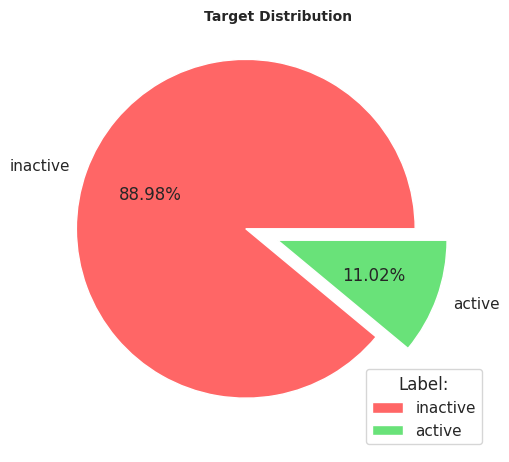

In [13]:
plt.figure(figsize=(5.5, 5.5))

labels = 'inactive', 'active'
colors = ['#FF6666', '#69E279']
myexplode = [0.2, 0]
plt.pie(data['target'].value_counts(), labels=labels, colors=colors, autopct='%1.2f%%', explode=myexplode)
plt.title('Target Distribution', fontsize=10, fontweight='bold')
plt.legend(title="Label:")
plt.savefig('target_distribution.png', dpi=300)
plt.show()

### **Frequency plot of the 2 bioactivity classes**

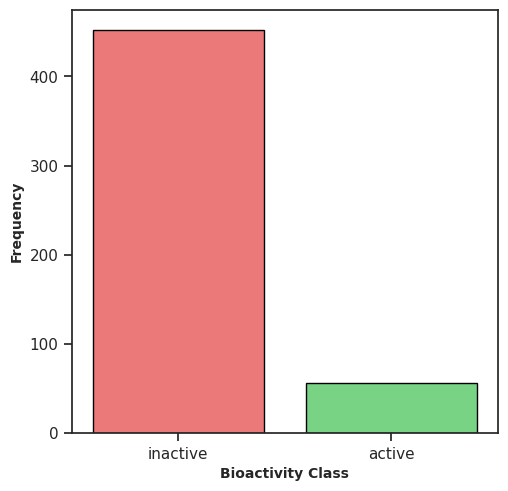

In [14]:
plt.figure(figsize=(5.5, 5.5))

colors = ['#FF6666', '#69E279']
sns.countplot(x='target', data=data, edgecolor='black', palette=colors)

plt.xlabel('Bioactivity Class', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')

plt.savefig('plot_bioactivity_class.png', dpi=300)

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

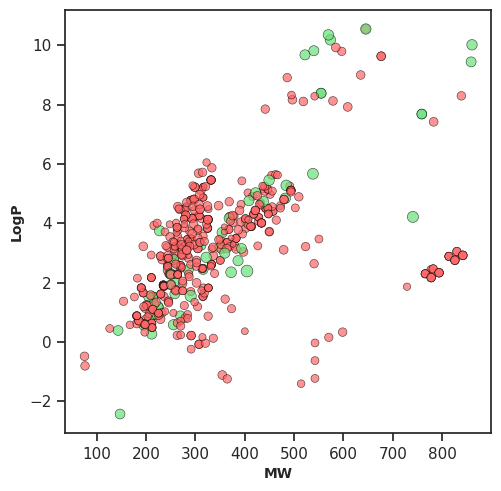

In [15]:
plt.figure(figsize=(5.5, 5.5))

colors = ['#FF6666', '#69E279']
sns.scatterplot(x='MW', y='LogP', data=data, hue='target', size='pIC50', edgecolor='black', alpha=0.7, legend=False, palette=colors)

plt.xlabel('MW', fontsize=10, fontweight='bold')
plt.ylabel('LogP', fontsize=10, fontweight='bold')

plt.savefig('plot_MW_vs_LogP.png', dpi=300)

Most of the compounds have a molecular weight of between 200 and 500 Da and logP values between 1 and 6. This is reasonable as drugs with MW>500 and logP>5 tend to lead to poor absorption. Good absorption is needed for orally administered drugs. 

### **Box plots**

#### **pIC50 value**

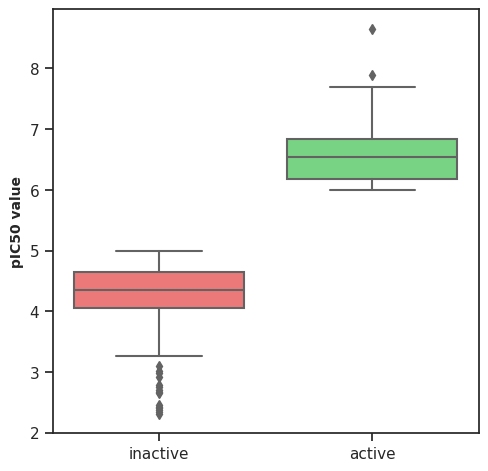

In [16]:
plt.figure(figsize=(5.5, 5.5))

colors = ['#FF6666', '#69E279']
sns.boxplot(x='target', y='pIC50', data=data, palette=colors)
plt.xlabel('', fontsize=10, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=10, fontweight='bold')

plt.savefig('plot_pIC50.png', dpi=300)

**Statistical analysis | Mann-Whitney U Test**

In [17]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'target']
  df = data[selection]
  active = df[df['target'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'target']
  df = data[selection]
  inactive = df[df['target'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

**Statistical analysis | Mann-Whitney U Test**

In [18]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,25312.0,2.624911e-34,0.05,Different distribution (reject H0)


As expected, the pIC50 values for active compounds are lower than for inactive compounds.

#### **MW**

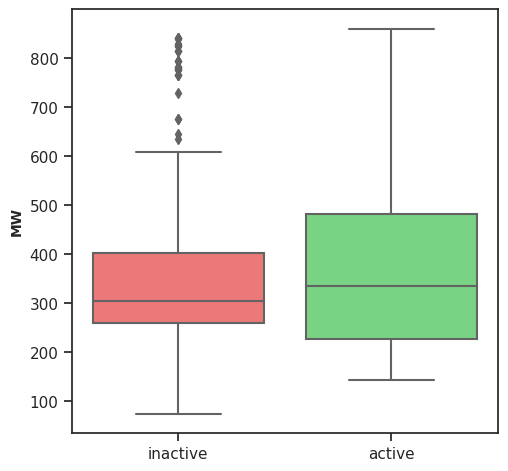

In [19]:
plt.figure(figsize=(5.5, 5.5))

colors = ['#FF6666', '#69E279']
sns.boxplot(x='target', y='MW', data=data, palette=colors)
plt.xlabel('', fontsize=10, fontweight='bold')
plt.ylabel('MW', fontsize=10, fontweight='bold')

plt.savefig('plot_MW.png', dpi=300)

**Statistical analysis | Mann-Whitney U Test**

In [20]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,13182.0,0.612043,0.05,Same distribution (fail to reject H0)


#### **LogP**

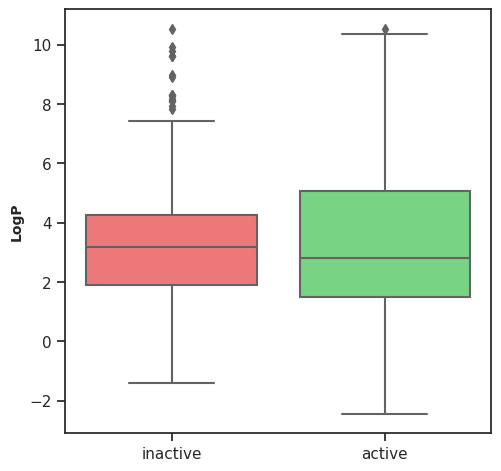

In [21]:
plt.figure(figsize=(5.5, 5.5))

colors = ['#FF6666', '#69E279']
sns.boxplot(x='target', y='LogP', data=data, palette=colors)
plt.xlabel('', fontsize=10, fontweight='bold')
plt.ylabel('LogP', fontsize=10, fontweight='bold')

plt.savefig('plot_LogP.png', dpi=300)

**Statistical analysis | Mann-Whitney U Test**

In [22]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,12814.5,0.878804,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

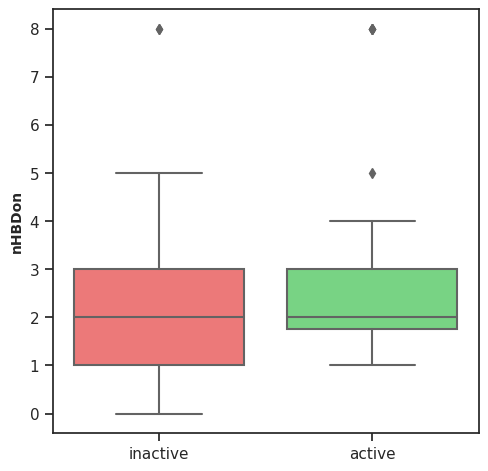

In [23]:
plt.figure(figsize=(5.5, 5.5))

colors = ['#FF6666', '#69E279']
sns.boxplot(x='target', y='nHBDon', data=data, palette=colors)
plt.xlabel('', fontsize=10, fontweight='bold')
plt.ylabel('nHBDon', fontsize=10, fontweight='bold')

plt.savefig('plot_NumHDonors.png', dpi=300)

**Statistical analysis | Mann-Whitney U Test**

In [24]:
mannwhitney('nHBDon')

,Descriptor,Statistics,p,alpha,Interpretation
0,nHBDon,13365.5,0.476718,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

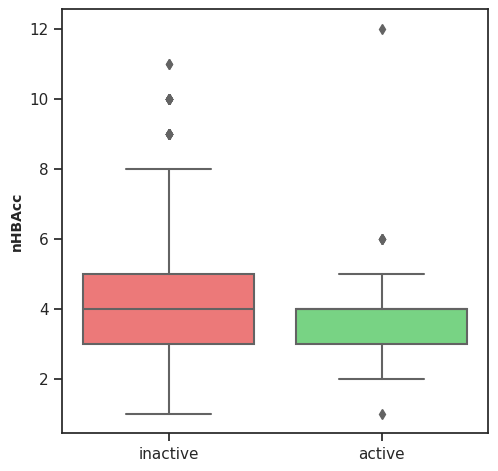

In [25]:
plt.figure(figsize=(5.5, 5.5))

colors = ['#FF6666', '#69E279']
sns.boxplot(x='target', y='nHBAcc', data=data, palette=colors)
plt.xlabel('', fontsize=10, fontweight='bold')
plt.ylabel('nHBAcc', fontsize=10, fontweight='bold')

plt.savefig('plot_NumHAcceptors.png', dpi=300)

**Statistical analysis | Mann-Whitney U Test**

In [26]:
mannwhitney('nHBAcc')

,Descriptor,Statistics,p,alpha,Interpretation
0,nHBAcc,11857.0,0.430941,0.05,Same distribution (fail to reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 <= 1000 nM = Actives while IC50 >= 10000 nM = Inactives``, corresponding to ``pIC50 >= 6 = Actives and pIC50 <= 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Based on the boundaries of the boxes, there are no differences between the two bioactivity classes for MW, LogP, nHBDon and nHBAcc. 

---



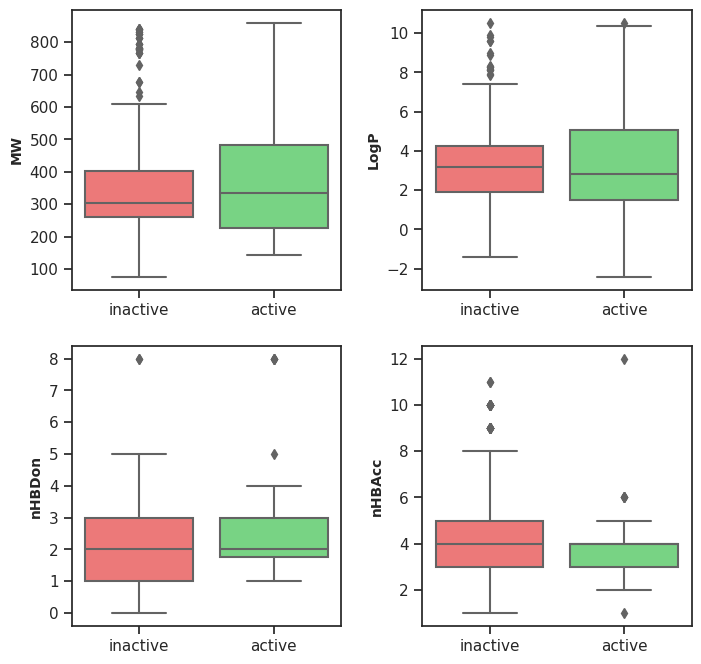

In [27]:
# create four sample plots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
colors = ['#FF6666', '#69E279']

sns.boxplot(x='target', y='MW', data=data, palette=colors, ax=axs[0, 0])
axs[0, 0].set_xlabel('', fontsize=10, fontweight='bold')
axs[0, 0].set_ylabel('MW', fontsize=10, fontweight='bold')

sns.boxplot(x='target', y='LogP', data=data, palette=colors, ax=axs[0, 1])
axs[0, 1].set_xlabel('', fontsize=10, fontweight='bold')
axs[0, 1].set_ylabel('LogP', fontsize=10, fontweight='bold')

sns.boxplot(x='target', y='nHBDon', data=data, palette=colors, ax=axs[1, 0])
axs[1, 0].set_xlabel('', fontsize=10, fontweight='bold')
axs[1, 0].set_ylabel('nHBDon', fontsize=10, fontweight='bold')

sns.boxplot(x='target', y='nHBAcc', data=data, palette=colors, ax=axs[1, 1])
axs[1, 1].set_xlabel('', fontsize=10, fontweight='bold')
axs[1, 1].set_ylabel('nHBAcc', fontsize=10, fontweight='bold')

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.2)

sns.set_style("whitegrid", {'axes.grid': False})

plt.savefig('plot_4_boxplots.png', dpi=300)

In [28]:
! zip lab2.zip *

  adding: bioactivity_combined_data.csv (deflated 76%)
  adding: bioactivity_data_2class.csv (deflated 76%)
  adding: mannwhitneyu_LogP.csv (deflated 8%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: mannwhitneyu_nHBAcc.csv (deflated 10%)
  adding: mannwhitneyu_nHBDon.csv (deflated 9%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: plot_4_boxplots.png (deflated 29%)
  adding: plot_bioactivity_class.png (deflated 33%)
  adding: plot_LogP.png (deflated 37%)
  adding: plot_MW.png (deflated 33%)
  adding: plot_MW_vs_LogP.png (deflated 5%)
  adding: plot_NumHAcceptors.png (deflated 37%)
  adding: plot_NumHDonors.png (deflated 37%)
  adding: plot_pIC50.png (deflated 34%)
  adding: sample_data/ (stored 0%)
  adding: target_distribution.png (deflated 18%)
